In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("./clean_tweets.csv", sep=",")
df.head()

,stem_token,score
0,real reason sad attach peopl distant pay atten...,1
1,biggest problem overthink everyth,1
2,worst sad sad teach hide,1
3,cannot make understand cannot make anyon under...,1
4,think anyon realli understand tire act okay al...,1


In [ ]:
df.dtypes

stem_token    object
score          int64
dtype: object

In [ ]:
seqlen = df["stem_token"].apply(lambda x: len(str(x).split(" ")))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


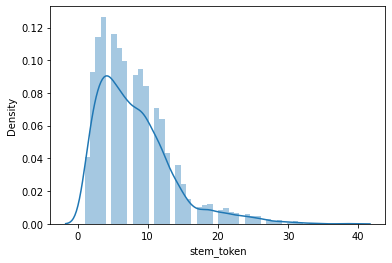

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.distplot(seqlen)

In [ ]:
max_length = 30

In [ ]:
model_name = "bert-base-cased"

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokens = tokenizer.encode_plus(
    "hello world",
    max_length=max_length,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)

In [ ]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
all_tokens = []

In [ ]:
for idx, data in enumerate(df["stem_token"]):
    all_tokens.append(
        tokenizer.encode_plus(
            str(data),
            max_length=max_length,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="tf",
        )
    )

In [ ]:
len(all_tokens)

7745

In [ ]:
X_ids = []
X_masks = []

In [ ]:
for tokens in all_tokens:
    X_ids.append(np.array(tokens["input_ids"]))
    X_masks.append(np.array(tokens["attention_mask"]))

In [ ]:
X_ids = np.array(X_ids)
X_masks = np.array(X_masks)

In [ ]:
labels = df["score"]
labels = np.array(labels)

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((X_ids, X_masks, labels))

In [ ]:
for i in ds.take(1):
    print(i)

(<tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[  101,  1842,  2255,  6782, 25337,   185,  8209,  1643,  1233,
         6531,  2653,  1120,  5208,  1204,   185,  8209,  1643,  1233,
          178, 25566,  1197,  1294,  1159,   185,  8209,  1643,  1233,
         3592,  1182,   102]], dtype=int32)>, <tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
def format_data(input_ids, masks, labels):
    return {"input_ids": input_ids[0], "attention_mask": masks[0]}, labels

In [ ]:
ds = ds.map(format_data)

In [ ]:
for i in ds.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  1842,  2255,  6782, 25337,   185,  8209,  1643,  1233,
        6531,  2653,  1120,  5208,  1204,   185,  8209,  1643,  1233,
         178, 25566,  1197,  1294,  1159,   185,  8209,  1643,  1233,
        3592,  1182,   102], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
ds = ds.shuffle(1000000).batch(32)

In [ ]:
ds_len = len(list(ds))

In [ ]:
ds_len

243

In [ ]:
train_ds = ds.take(round(0.8 * ds_len))
val_ds = ds.skip(round(0.8 * ds_len))

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from tensorflow import keras

In [ ]:
input_ids = keras.layers.Input(shape=(max_length,), name="input_ids", dtype="int32")
mask = keras.layers.Input(shape=(max_length,), name="attention_mask", dtype="int32")
embeddings = bert(input_ids, attention_mask=mask)[0]
X = keras.layers.GlobalMaxPool1D()(embeddings)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(128, activation="relu")(X)
X = keras.layers.Dropout(0.1)(X)
X = keras.layers.Dense(32, activation="relu")(X)
y = keras.layers.Dense(2, activation="softmax", name="outputs")(X)

model = keras.Model(inputs=[input_ids, mask], outputs=[y])
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [ ]:
optimizer = keras.optimizers.Adam(0.01)
loss = keras.losses.SparseCategoricalCrossentropy()
acc = keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=48)

Epoch 1/48
194/194 [==============================] - 37s 122ms/step - loss: 0.5223 - accuracy: 0.7563 - val_loss: 0.3875 - val_accuracy: 0.8289
Epoch 2/48
194/194 [==============================] - 18s 94ms/step - loss: 0.4351 - accuracy: 0.8094 - val_loss: 0.4376 - val_accuracy: 0.7925
Epoch 3/48
194/194 [==============================] - 18s 94ms/step - loss: 0.4370 - accuracy: 0.8041 - val_loss: 0.3672 - val_accuracy: 0.8146
Epoch 4/48
194/194 [==============================] - 22s 112ms/step - loss: 0.4103 - accuracy: 0.8162 - val_loss: 0.3572 - val_accuracy: 0.8705
Epoch 5/48
194/194 [==============================] - 19s 95ms/step - loss: 0.4195 - accuracy: 0.8151 - val_loss: 0.3508 - val_accuracy: 0.8341
Epoch 6/48
194/194 [==============================] - 19s 95ms/step - loss: 0.4051 - accuracy: 0.8191 - val_loss: 0.3182 - val_accuracy: 0.8673
Epoch 7/48
194/194 [==============================] - 19s 98ms/step - loss: 0.4014 - accuracy: 0.8239 - val_loss: 0.3377 - val_accurac

In [ ]:
history

In [ ]:
model.save("./model.h5")

In [ ]:
import matplotlib.pyplot as plt

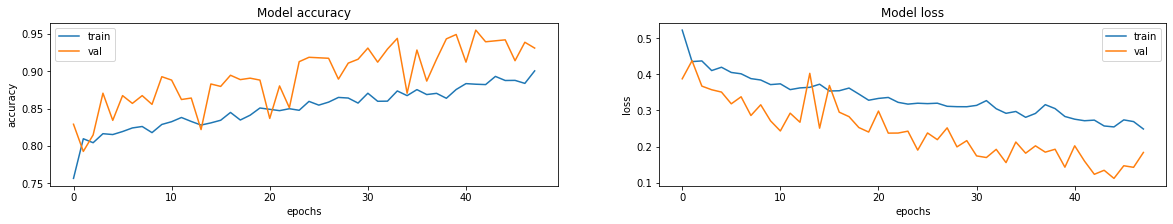

In [ ]:
import matplotlib.pyplot as plt

ig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])